# FORMULA 1 DATA ANALYSIS

## Obiettivo del progetto

L'obiettivo del lavoro è analizzare il mondiale di Formula 1 2024, fornendo statistiche principali su piloti e team, con un focus approfondito sul Gran Premio di Monaco.  
Si intende esplorare l'importanza della posizione di partenza in qualifica rispetto al risultato in gara, utilizzando dati completi di telemetria, strategie gomme e condizioni meteo forniti da FastF1.  
Il progetto mira a combinare analisi descrittive e visualizzazioni per evidenziare le determinanti chiave della performance.


In [1]:
!pip install fastf1 matplotlib pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 67.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
  Attempting uninstall: attrs
    Found existing installation: attrs 25.3.0
    Uninstalling attrs-25.3.0:
      Successfully uninstalled attrs-25.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires

In [ ]:
import os
import fastf1
import pandas as pd
import warnings
import logging
from tqdm.notebook import tqdm

# Silenzia warning e log non necessari
warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.ERROR)

# Configura cache locale 
os.makedirs('/kaggle/working/cache', exist_ok=True)
fastf1.Cache.enable_cache('/kaggle/working/cache')

# Stagione da analizzare
season = 2024
schedule = fastf1.get_event_schedule(season)

all_results = []

# Carica ogni gara (salta test, round 0)
for rnd in tqdm(schedule[schedule.RoundNumber > 0].RoundNumber, desc="Caricamento gare"):
    event = fastf1.get_event(season, rnd)
    try:
        session = event.get_session('R')
        session.load()
        df = session.results.copy()
        df['Round'] = rnd
        df['DriverName'] = df['FirstName'] + ' ' + df['LastName'] if 'FirstName' in df.columns else df['Driver']
        all_results.append(df[['DriverName', 'TeamName', 'Points', 'Round']])
        
    except Exception:
        continue

# Aggrega punti per pilota
drivers_df = pd.concat(all_results)
drivers_final = (
    drivers_df.groupby('DriverName', as_index=False)['Points']
    .sum()
    .sort_values('Points', ascending=False)
    .reset_index(drop=True)
)
drivers_final.index += 1

print("=== CLASSIFICA PILOTI 2024 ===")
display(drivers_final)

# Aggrega punti per team
constructors_final = (
    drivers_df.groupby('TeamName', as_index=False)['Points']
    .sum()
    .sort_values('Points', ascending=False)
    .reset_index(drop=True)
)
constructors_final.index += 1

print("=== CLASSIFICA COSTRUTTORI 2024 ===")
display(constructors_final)


Caricamento gare:   0%|          | 0/24 [00:00<?, ?it/s]

=== CLASSIFICA PILOTI 2024 ===


Il mondiale F1 2024 ha visto **Max Verstappen** vincitore del mondiale piloti e la **McLaren** vincitrice del mondiale costruttori.  

Un aspetto fondamentale dei mondiali sono i punti ottenuti in gara. Durante una gara entrano in gioco diversi fattori:

- **Esperienza del pilota**: conoscenza del circuito e capacità di gestione della gara in diverse situazioni.  
- **Sviluppo della vettura**: incide principalmente sulle prestazioni complessive in gara.  
- **Strategia del team**: permette di adottare contromisure rispetto alle scelte degli avversari.  
- **Meteo**: condizioni climatiche influenzano gomme, pit stop e comportamento della vettura.



In [4]:
import pandas as pd
from pathlib import Path

# Percorso base cache
base_cache_path = Path('/kaggle/working/cache/2024')

# Disabilita troncamento
pd.set_option('display.max_colwidth', None)

# Funzione per ottenere il nome del pilota da ID
def get_driver_name(driver_info, driver_id):
    info = driver_info.get(driver_id, {})
    return info.get('FullName', str(driver_id))

# Funzione per convertire timedelta in mm:ss.SSS
def format_lap_time(td):
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Funzione per trasformare la strategia in stringa (solo cambi reali di gomma)
def strategy_to_string(df):
    df = df.dropna(subset=['Compound'])
    df = df[df['Compound'].str.lower() != 'unknown']
    df = df.sort_values('LapNumber')

    compounds = []
    last_compound = None
    for c in df['Compound']:
        if c != last_compound:
            compounds.append(c)
            last_compound = c

    return " / ".join(compounds)

# Lista per raccogliere i risultati di tutte le gare
all_races = []

# Ciclo su tutte le sottocartelle *_Race di tutte le gare
for race_folder in sorted(base_cache_path.glob('*/*_Race')):
    try:
        # File principali
        extended_file = race_folder / '_extended_timing_data.ff1pkl'
        timing_file = race_folder / 'timing_app_data.ff1pkl'
        driver_file = race_folder / 'driver_info.ff1pkl'

        if not extended_file.exists() or not timing_file.exists() or not driver_file.exists():
            continue

        # Carica pickle
        extended_data = pd.read_pickle(extended_file)['data']
        timing_data = pd.read_pickle(timing_file)['data']
        driver_info = pd.read_pickle(driver_file)['data']

        # DataFrame principali
        laps_df = extended_data[0]
        positions_df = extended_data[1]
        timing_df = timing_data

        # Estrai data e nome gara dalla cartella padre
        parent_name = race_folder.parent.name  # es. "2024-03-02_Bahrain_Grand_Prix"
        race_date, race_title = parent_name.split('_', 1)
        race_name = race_title.replace('_', ' ')

        # Vincitore
        winner_id = positions_df.loc[positions_df['Position'] == 1, 'Driver'].iloc[0]
        winner_name = get_driver_name(driver_info, winner_id)
        winner_best_lap = laps_df[laps_df['Driver'] == winner_id]['LapTime'].min()
        winner_best_lap_str = format_lap_time(winner_best_lap)
        winner_strategy_df = timing_df[timing_df['Driver'] == winner_id][['LapNumber', 'Stint', 'Compound']].drop_duplicates()
        winner_strategy_str = strategy_to_string(winner_strategy_df)

        # Pilota con giro veloce
        fastest_row = laps_df.loc[laps_df['LapTime'] == laps_df['LapTime'].min()].iloc[0]
        fastest_driver_id = fastest_row['Driver']
        fastest_driver_name = get_driver_name(driver_info, fastest_driver_id)
        fastest_lap = fastest_row['LapTime']
        fastest_lap_str = format_lap_time(fastest_lap)
        fastest_strategy_df = timing_df[timing_df['Driver'] == fastest_driver_id][['LapNumber', 'Stint', 'Compound']].drop_duplicates()
        fastest_strategy_str = strategy_to_string(fastest_strategy_df)

        # Aggiungi al riepilogo
        all_races.append({
            'Date': race_date,
            'Race': race_name,
            'FastestDriver': fastest_driver_name,
            'FastestLap': fastest_lap_str,
            'FastestDriverStrategy': fastest_strategy_str,
            'Winner': winner_name,
            'WinnerBestLap': winner_best_lap_str,
            'WinnerStrategy': winner_strategy_str
        })

    except Exception as e:
        print(f"Errore nella gara {race_folder}: {e}")
        continue

# DataFrame finale con tutte le gare
race_summary_df = pd.DataFrame(all_races)

display(race_summary_df)


,Date,Race,FastestDriver,FastestLap,FastestDriverStrategy,Winner,WinnerBestLap,WinnerStrategy
0,2024-03-02,Bahrain Grand Prix,Max VERSTAPPEN,01:32.608,SOFT / HARD / SOFT,Max VERSTAPPEN,01:32.608,SOFT / HARD / SOFT
1,2024-03-09,Saudi Arabian Grand Prix,Charles LECLERC,01:31.632,MEDIUM / HARD,Max VERSTAPPEN,01:31.773,MEDIUM / HARD
2,2024-03-24,Australian Grand Prix,Charles LECLERC,01:19.813,MEDIUM / HARD,Max VERSTAPPEN,01:23.115,MEDIUM
3,2024-04-07,Japanese Grand Prix,Max VERSTAPPEN,01:33.706,MEDIUM / HARD,Max VERSTAPPEN,01:33.706,MEDIUM / HARD
4,2024-04-21,Chinese Grand Prix,Fernando ALONSO,01:37.810,MEDIUM / HARD / SOFT / MEDIUM,Max VERSTAPPEN,01:38.406,MEDIUM / HARD
5,2024-05-05,Miami Grand Prix,Oscar PIASTRI,01:30.634,MEDIUM / HARD / MEDIUM,Max VERSTAPPEN,01:31.261,MEDIUM / HARD
6,2024-05-19,Emilia Romagna Grand Prix,George RUSSELL,01:18.589,MEDIUM / HARD / MEDIUM,Max VERSTAPPEN,01:20.366,MEDIUM / HARD
7,2024-05-26,Monaco Grand Prix,Lewis HAMILTON,01:14.165,HARD / MEDIUM / HARD,Charles LECLERC,01:15.162,MEDIUM / HARD
8,2024-06-09,Canadian Grand Prix,Lewis HAMILTON,01:14.856,INTERMEDIATE / MEDIUM / HARD,George RUSSELL,01:14.895,INTERMEDIATE / HARD / MEDIUM
9,2024-06-23,Spanish Grand Prix,Lando NORRIS,01:17.115,SOFT / MEDIUM / SOFT,Lando NORRIS,01:17.115,SOFT / MEDIUM / SOFT


In [6]:
# 1. Coincidenza tra vincitore e giro veloce
same_driver = race_summary_df[race_summary_df['Winner'] == race_summary_df['FastestDriver']]
diff_driver = race_summary_df[race_summary_df['Winner'] != race_summary_df['FastestDriver']]

same_count = len(same_driver)
total_count = len(race_summary_df)
perc_same = same_count / total_count * 100

print(f"Gare con stesso vincitore e giro veloce: {same_count}/{total_count} ({perc_same:.1f}%)")

# 2. Differenza media nei casi diversi
def time_to_seconds(t):
    m, s = t.split(':')
    return int(m) * 60 + float(s)

diff_driver = diff_driver.copy()
diff_driver['FastestLap_sec'] = diff_driver['FastestLap'].apply(time_to_seconds)
diff_driver['WinnerBestLap_sec'] = diff_driver['WinnerBestLap'].apply(time_to_seconds)
diff_driver['LapDiff_sec'] = diff_driver['WinnerBestLap_sec'] - diff_driver['FastestLap_sec']

mean_diff = diff_driver['LapDiff_sec'].mean()

# Conversione in formato mm:ss.SSS
minutes = int(mean_diff // 60)
seconds = mean_diff % 60
mean_diff_str = f"{minutes:02d}:{seconds:06.3f}"

print(f"Differenza media tra giro veloce e miglior giro del vincitore (quando diversi): {mean_diff_str}")

# 3. Numero di gare in cui il vincitore ha usato le soft
race_summary_df['WinnerUsedSoft'] = race_summary_df['WinnerStrategy'].str.contains('SOFT')
soft_count = race_summary_df['WinnerUsedSoft'].sum()
perc_soft = soft_count / total_count * 100

print(f"Gare in cui il vincitore ha utilizzato le SOFT: {soft_count}/{total_count} ({perc_soft:.1f}%)")


Gare con stesso vincitore e giro veloce: 5/24 (20.8%)
Differenza media tra giro veloce e miglior giro del vincitore (quando diversi): 00:01.226
Gare in cui il vincitore ha utilizzato le SOFT: 3/24 (12.5%)


Dai dati raccolti su tutte le gare 2024, emergono le seguenti osservazioni:

### 1. Coincidenza vincitore / giro veloce
- Solo il **20,8%** delle gare ha visto il vincitore anche autore del giro più veloce.
- Nella maggior parte delle gare, la vittoria dipende più dalla **costanza, gestione strategica e scelta dei pit stop** che dalla pura velocità sul singolo giro.

### 2. Differenza media tra giro veloce e miglior giro del vincitore
- Quando i piloti sono diversi, la differenza media è di **00:01.226**.
- Il vincitore resta molto competitivo anche sul passo, mentre chi realizza il giro più veloce tende a sfruttare **stint più aggressivi o mescole più morbide**.

### 3. Uso delle gomme soft da parte del vincitore
- Solo il **12,5%** delle gare ha visto il vincitore utilizzare le gomme soft nella sua strategia.
- L’impiego delle soft è quindi **mirato e tattico**, ad esempio per consolidare un vantaggio o ottenere il giro più veloce, ma non rappresenta la strategia standard.

### 4. Deduzioni complessive
- La **strategia di gara** ha un ruolo più determinante della velocità assoluta per la vittoria.
- Le differenze prestazionali tra i top team sono **molto ridotte**, con gap medi di circa 1–2 secondi.
- L’esperienza del pilota, lo sviluppo della vettura e le decisioni del team in termini di **gestione delle gomme e tempistica dei pit stop** risultano fattori chiave.


## Super Time (SuperTimes)

Il concetto di **Super Time** rappresenta una misura comparativa delle prestazioni dei piloti all'interno di una stessa scuderia. 

### Definizione
- Per ogni gara, si calcola il miglior giro di ciascun pilota.
- Il **Super Time** di ciascun pilota è dato dal rapporto tra il suo miglior giro e il miglior giro della scuderia:

  SuperTime% = (Giro del pilota / Giro migliore del team) × 100

- Viene quindi calcolata la **media tra i due piloti** per ottenere un unico valore rappresentativo della scuderia.

### Interpretazione
- Un valore del **100%** indica che il pilota ha segnato il giro più veloce della scuderia.
- Valori superiori al 100% indicano quanto più lento è stato il giro rispetto al migliore della scuderia.
- Il Super Time permette di confrontare facilmente le prestazioni dei team tra le diverse gare.

### Visualizzazione
- Nel grafico, ogni linea rappresenta l'andamento del Super Time medio di ciascuna scuderia nel corso della stagione.
- Colori specifici sono associati a ciascuna scuderia per una facile identificazione.


In [7]:
import pandas as pd
from pathlib import Path

# Percorso base cache
base_cache_path = Path('/kaggle/working/cache/2024')

# Disabilita troncamento
pd.set_option('display.max_colwidth', None)

# Funzione per ottenere il nome del pilota da ID
def get_driver_name(driver_info, driver_id):
    info = driver_info.get(driver_id, {})
    return info.get('FullName', str(driver_id))

# Funzione per convertire timedelta in mm:ss.SSS
def format_lap_time(td):
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Lista per raccogliere i risultati di tutte le gare
all_races = []

# Ciclo su tutte le sottocartelle *_Race di tutte le gare
for race_folder in sorted(base_cache_path.glob('*/*_Race')):
    try:
        # File principali
        extended_file = race_folder / '_extended_timing_data.ff1pkl'
        driver_file = race_folder / 'driver_info.ff1pkl'

        if not extended_file.exists() or not driver_file.exists():
            continue

        # Carica pickle
        extended_data = pd.read_pickle(extended_file)['data']
        driver_info = pd.read_pickle(driver_file)['data']

        # DataFrame dei giri
        laps_df = extended_data[0]

        # Dizionario pilota -> team
        driver_team = {driver_id: info.get('TeamName', 'Unknown') for driver_id, info in driver_info.items()}
        laps_df['Team'] = laps_df['Driver'].map(driver_team)

        # Filtra giri validi
        laps_df_valid = laps_df[laps_df['LapTime'].notna()].copy()

        # Miglior giro per pilota
        best_laps = laps_df_valid.groupby(['Driver', 'Team'])['LapTime'].min().reset_index()

        # Miglior giro per team
        best_team_laps = best_laps.groupby('Team')['LapTime'].min().reset_index()
        best_team_laps.rename(columns={'LapTime': 'BestLapTeam'}, inplace=True)

        # Unisci per ottenere SuperTime dei piloti
        best_laps = best_laps.merge(best_team_laps, on='Team')
        best_laps['SuperTime%'] = best_laps['LapTime'] / best_laps['BestLapTeam'] * 100

        # Formatta i tempi
        best_laps['BestLap_str'] = best_laps['LapTime'].apply(format_lap_time)
        best_laps['BestLapTeam_str'] = best_laps['BestLapTeam'].apply(format_lap_time)

        # Media SuperTime% per team
        team_supertime = best_laps.groupby('Team')['SuperTime%'].mean().reset_index()
        team_supertime.rename(columns={'SuperTime%': 'SuperTime%_mean'}, inplace=True)

        # Unisci con il miglior giro del pilota
        best_pilot_per_team = best_laps.loc[best_laps.groupby('Team')['LapTime'].idxmin()].copy()
        best_pilot_per_team = best_pilot_per_team.merge(team_supertime, on='Team')

        # Aggiungi ID gara (es. nome cartella)
        race_id = race_folder.parent.name
        best_pilot_per_team['RACE_ID'] = race_id

        # Rimuovi colonne SuperTime originali
        best_pilot_per_team.drop(columns=['SuperTime%', 'LapTime', 'BestLapTeam'], inplace=True)

        # Aggiungi al DataFrame finale
        all_races.append(best_pilot_per_team)

    except Exception as e:
        print(f"Errore nella gara {race_folder}: {e}")
        continue

# DataFrame finale con tutte le gare
final_df = pd.concat(all_races, ignore_index=True)

display(final_df)


,Driver,Team,BestLap_str,BestLapTeam_str,SuperTime%_mean,RACE_ID
0,10,Alpine,01:34.805,01:34.805,100.749433,2024-03-02_Bahrain_Grand_Prix
1,14,Aston Martin,01:34.199,01:34.199,100.760624,2024-03-02_Bahrain_Grand_Prix
2,16,Ferrari,01:34.090,01:34.090,100.221596,2024-03-02_Bahrain_Grand_Prix
3,27,Haas F1 Team,01:34.834,01:34.834,100.388046,2024-03-02_Bahrain_Grand_Prix
4,24,Kick Sauber,01:35.458,01:35.458,100.389700,2024-03-02_Bahrain_Grand_Prix
...,...,...,...,...,...,...
234,4,McLaren,01:27.438,01:27.438,100.144102,2024-12-08_Abu_Dhabi_Grand_Prix
235,44,Mercedes,01:27.278,01:27.278,100.525333,2024-12-08_Abu_Dhabi_Grand_Prix
236,30,RB,01:28.751,01:28.751,100.252955,2024-12-08_Abu_Dhabi_Grand_Prix
237,1,Red Bull Racing,01:27.765,01:27.765,100.000000,2024-12-08_Abu_Dhabi_Grand_Prix


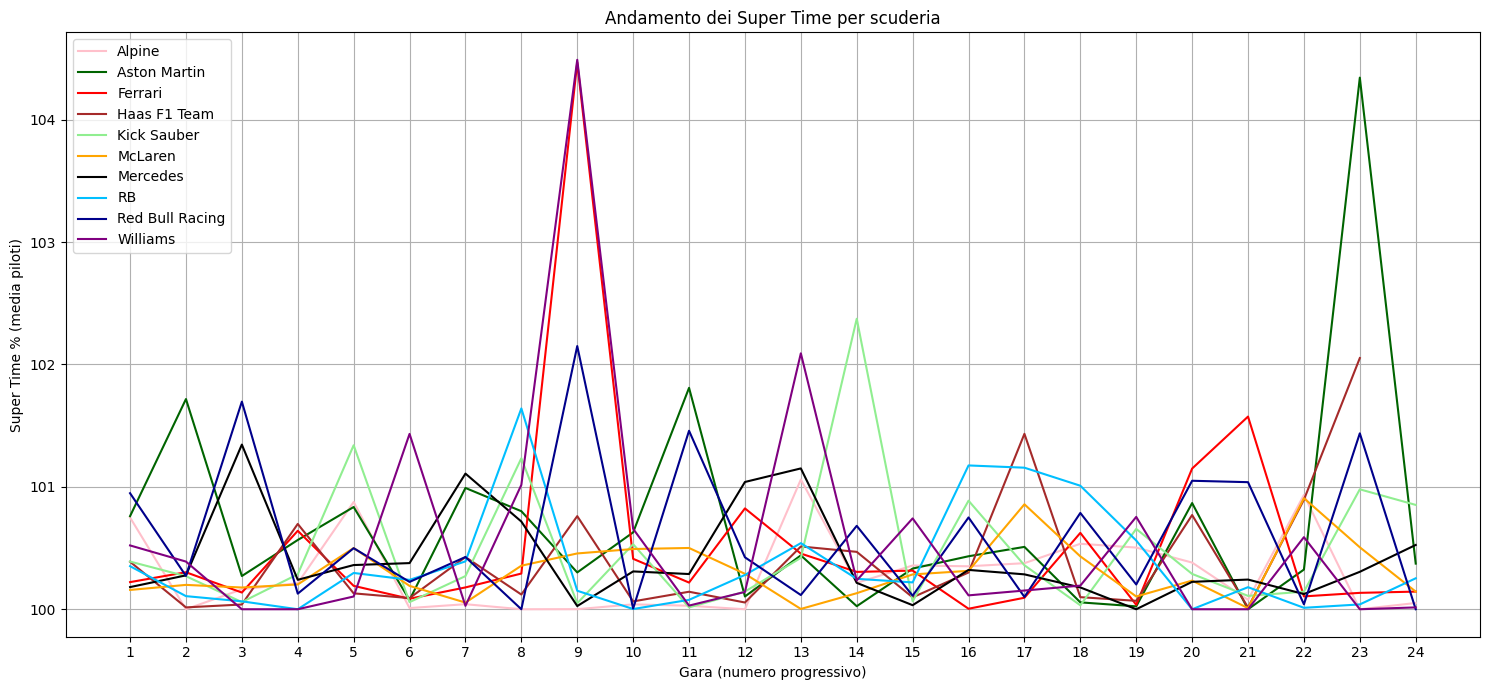

In [8]:
import matplotlib.pyplot as plt

# Mappa colori personalizzata per team
team_colors = {
    'Alpine': 'pink',
    'Aston Martin': 'darkgreen',
    'Ferrari': 'red',
    'Haas F1 Team': 'brown',  # colore scelto
    'Kick Sauber': 'lightgreen',
    'McLaren': 'orange',
    'Mercedes': 'black',
    'RB': 'deepskyblue',
    'Red Bull Racing': 'darkblue',
    'Williams': 'purple'
}

plt.figure(figsize=(15, 7))

for team, color in team_colors.items():
    team_data = final_df[final_df['Team'] == team]
    plt.plot(range(1, len(team_data)+1), team_data['SuperTime%_mean'], label=team, color=color)

plt.xlabel('Gara (numero progressivo)')
plt.ylabel('Super Time % (media piloti)')
plt.title('Andamento dei Super Time per scuderia')
plt.xticks(range(1, 25))  # da 1 a 24
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Dal grafico si possono osservare alcune evidenze importanti sulle prestazioni delle scuderie:

- Nonostante Verstappen abbia vinto il mondiale, i Super Time della **Red Bull Racing** suggeriscono prestazioni più vicine a quelle di un costruttore di centro gruppo, piuttosto che di un team costantemente da podio.
- **Ferrari** e **Williams** hanno mostrato picchi negativi in Canada, coerenti con i piazzamenti ottenuti in quella gara, mentre **Aston Martin** ha avuto un calo significativo in Qatar.
- I team di centro gruppo evidenziano prestazioni molto altalenanti tra una gara e l'altra, mentre scuderie come **McLaren** e **Ferrari** (ad eccezione del picco in Canada) mantengono una linea di performance più stabile.
- La linea arancione della **McLaren** mostra chiaramente la consistenza delle loro prestazioni, spiegando il motivo per cui hanno vinto il mondiale costruttori.


Un fattore importante che influisce sulle prestazioni in gara delle vetture è la **temperatura dell'aria**.  
Quando le vetture spingono al massimo, diverse componenti interne, in particolare i **freni**, tendono a surriscaldarsi, rendendo le frenate più difficili e rallentando la vettura nelle curve.


In [11]:
import pandas as pd
from pathlib import Path

# Percorso base cache
base_cache_path = Path('/kaggle/working/cache/2024')

# Lista per raccogliere i risultati di tutti i GP
all_races_points = []

# Ciclo su tutte le sottocartelle *_Race
for race_folder in sorted(base_cache_path.glob('*/*_Race')):
    try:
        extended_file = race_folder / '_extended_timing_data.ff1pkl'
        driver_file = race_folder / 'driver_info.ff1pkl'
        weather_file = race_folder / 'weather_data.ff1pkl'

        if not extended_file.exists() or not driver_file.exists() or not weather_file.exists():
            continue

        # Carica pickle
        extended_data = pd.read_pickle(extended_file)['data']
        driver_info = pd.read_pickle(driver_file)['data']
        weather_data = pd.read_pickle(weather_file)['data']

        # Temperatura media aria
        air_temp_series = pd.Series(weather_data['AirTemp'])
        air_temp_mean = air_temp_series.mean()

        # DataFrame dei giri
        laps_df = extended_data[0]

        # Dizionario pilota -> team
        driver_team = {driver_id: info.get('TeamName', 'Unknown') for driver_id, info in driver_info.items()}
        laps_df['Team'] = laps_df['Driver'].map(driver_team)

        # Miglior giro per pilota
        best_laps = laps_df.groupby(['Driver', 'Team'])['LapTime'].min().reset_index()
        best_laps = best_laps.sort_values('LapTime')

        # Classifica punti (F1 standard 25-18-15-12-10-8-6-4-2-1)
        points_table = [25,18,15,12,10,8,6,4,2,1]
        best_laps['Points'] = 0
        for i, idx in enumerate(best_laps.index[:10]):
            best_laps.at[idx, 'Points'] = points_table[i]

        # Somma punti per team
        team_points = best_laps.groupby('Team')['Points'].sum().reset_index()
        team_points['AirTemp'] = air_temp_mean

        # Aggiungi ID GP
        race_id = race_folder.parent.name
        team_points['RACE_ID'] = race_id

        # Aggiungi al risultato finale
        all_races_points.append(team_points)

    except Exception as e:
        print(f"Errore nella gara {race_folder}: {e}")
        continue

# DataFrame finale con tutti i GP
final_races_points_df = pd.concat(all_races_points, ignore_index=True)

# Ordina per GP e punti decrescenti
final_races_points_df = final_races_points_df.sort_values(['RACE_ID','Points'], ascending=[True, False])

display(final_races_points_df)


,Team,Points,AirTemp,RACE_ID
8,Red Bull Racing,37,18.227389,2024-03-02_Bahrain_Grand_Prix
2,Ferrari,26,18.227389,2024-03-02_Bahrain_Grand_Prix
1,Aston Martin,15,18.227389,2024-03-02_Bahrain_Grand_Prix
5,McLaren,12,18.227389,2024-03-02_Bahrain_Grand_Prix
6,Mercedes,6,18.227389,2024-03-02_Bahrain_Grand_Prix
...,...,...,...,...
230,Aston Martin,6,26.768243,2024-12-08_Abu_Dhabi_Grand_Prix
233,Kick Sauber,4,26.768243,2024-12-08_Abu_Dhabi_Grand_Prix
229,Alpine,0,26.768243,2024-12-08_Abu_Dhabi_Grand_Prix
236,RB,0,26.768243,2024-12-08_Abu_Dhabi_Grand_Prix


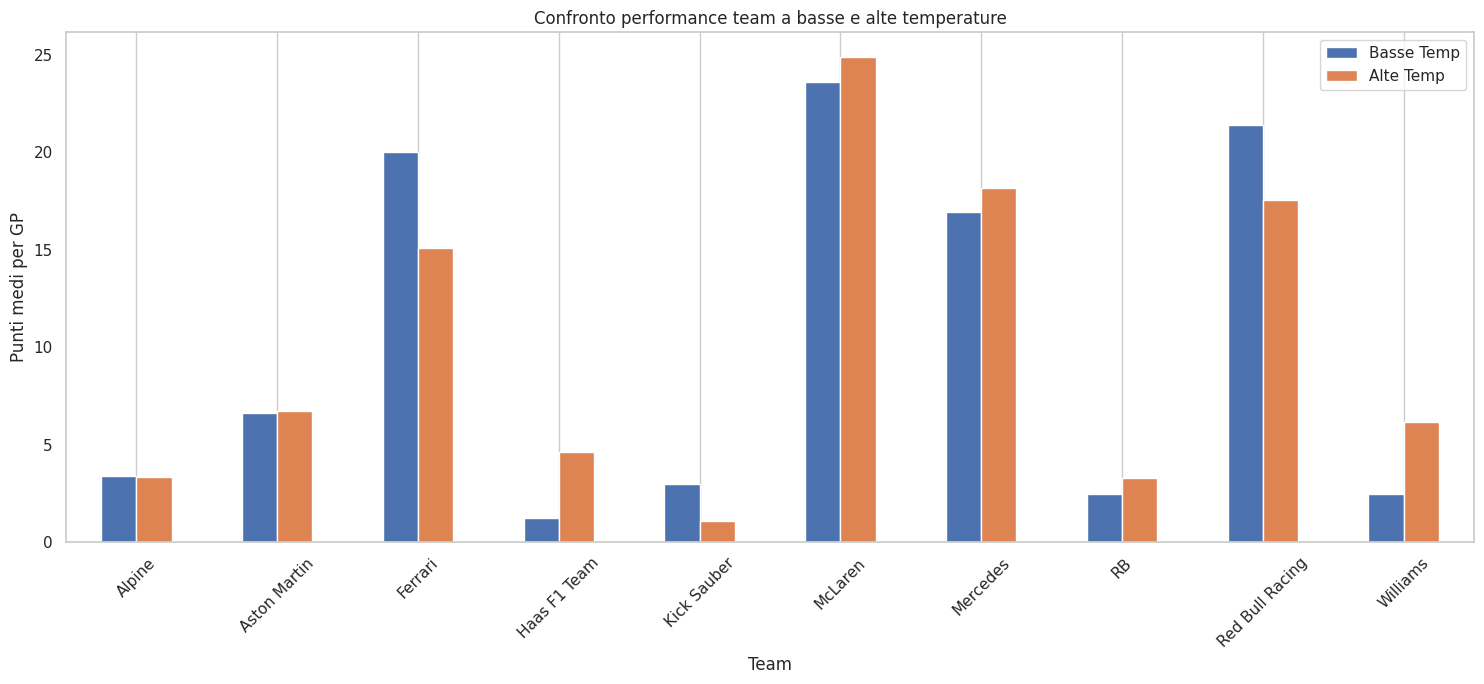

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Suddividi in basse e alte temperature (mediana)
temp_median = final_races_points_df['AirTemp'].median()

low_temp = final_races_points_df[final_races_points_df['AirTemp'] <= temp_median]
high_temp = final_races_points_df[final_races_points_df['AirTemp'] > temp_median]

# Punti medi per team
low_temp_avg = low_temp.groupby('Team')['Points'].mean()
high_temp_avg = high_temp.groupby('Team')['Points'].mean()

# Unisci in DataFrame
avg_points_df = pd.DataFrame({
    'Basse Temp': low_temp_avg,
    'Alte Temp': high_temp_avg
}).fillna(0)  # in caso di team assenti in una categoria

# Grafico a barre
avg_points_df.plot(kind='bar', figsize=(15, 7))
plt.ylabel('Punti medi per GP')
plt.title('Confronto performance team a basse e alte temperature')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Dal grafico emerge che alcuni costruttori soffrono particolarmente le alte temperature, come **Ferrari** e **Red Bull**, mentre altri performano peggio con temperature basse, come **Williams** e **Haas**.  
Gli altri team mostrano prestazioni più bilanciate al variare della temperatura.

In [ ]:
import os
import fastf1
import pandas as pd
import warnings
import logging
from tqdm.notebook import tqdm

# Silenzia warning e log non necessari
warnings.filterwarnings('ignore')
logging.getLogger('fastf1').setLevel(logging.ERROR)
logging.getLogger().setLevel(logging.ERROR)

# Configura cache locale 
os.makedirs('/kaggle/working/cache', exist_ok=True)
fastf1.Cache.enable_cache('/kaggle/working/cache')

# Stagione da analizzare
season = 2024
schedule = fastf1.get_event_schedule(season)

poles_list = []

for rnd in tqdm(schedule[schedule.RoundNumber > 0].RoundNumber, desc="Caricamento qualifiche"):
    event = fastf1.get_event(season, rnd)
    try:
        session_qualy = event.get_session('Q')
        session_qualy.load()
        df_qualy = session_qualy.results.copy()

        # Top 1 (pole)
        pole_row = df_qualy[df_qualy['Position'] == 1].iloc[0]

        # Applica formato mm:ss.SSS
        pole_time_str = format_lap_time(pole_row['Q3'])

        poles_list.append({
            'Round': rnd,
            'RaceName': event.EventName,
            'PoleDriver': f"{pole_row['FirstName']} {pole_row['LastName']}",
            'TeamName': pole_row['TeamName'],
            'PoleTime_str': pole_time_str
        })

    except Exception:
        continue

poles_df = pd.DataFrame(poles_list)
display(poles_df)


Caricamento qualifiche:   0%|          | 0/24 [00:00<?, ?it/s]

## Analisi dei Dati delle Qualifiche

In questa sezione vengono analizzati i dati delle qualifiche per ciascun team.  
L'obiettivo è confrontare le prestazioni in qualifica tra i diversi costruttori e osservare eventuali pattern o differenze rispetto ai dati registrati nelle gare.


In [9]:
import pandas as pd

# Unione tra i due DataFrame sulla colonna Race / RaceName
merged_df = pd.merge(
    poles_df,
    race_summary_df,
    left_on="RaceName",
    right_on="Race",
    how="inner"
)

# Selezione colonne richieste
comparison_df = merged_df[["RaceName", "PoleDriver", "Winner"]].copy()
comparison_df.rename(columns={
    "RaceName": "Gara",
    "PoleDriver": "Pole Position",
    "Winner": "Vincitore"
}, inplace=True)

# Calcolo percentuale di vittorie partendo dalla pole (case-insensitive)
pole_wins = (
    comparison_df["Pole Position"].str.lower().str.strip()
    == comparison_df["Vincitore"].str.lower().str.strip()
).sum()

total_races = len(comparison_df)
percent_pole_wins = (pole_wins / total_races) * 100

print(f"Percentuale di vittorie partendo dalla pole position: {percent_pole_wins:.2f}%")

display(comparison_df)


Percentuale di vittorie partendo dalla pole position: 94.12%


,Gara,Pole Position,Vincitore
0,Bahrain Grand Prix,Max Verstappen,Max VERSTAPPEN
1,Saudi Arabian Grand Prix,Max Verstappen,Max VERSTAPPEN
2,Australian Grand Prix,Max Verstappen,Max VERSTAPPEN
3,Japanese Grand Prix,Max Verstappen,Max VERSTAPPEN
4,Chinese Grand Prix,Max Verstappen,Max VERSTAPPEN
5,Miami Grand Prix,Max Verstappen,Max VERSTAPPEN
6,Emilia Romagna Grand Prix,Max Verstappen,Max VERSTAPPEN
7,Monaco Grand Prix,Charles Leclerc,Charles LECLERC
8,Canadian Grand Prix,George Russell,George RUSSELL
9,Spanish Grand Prix,Lando Norris,Lando NORRIS


Dal primo mondiale disputato nel 1950, la media della conversione pole-vittoria è di circa il 42%. Dai dati emerge che nel 2024 la pole position ha inciso fortemente sull’esito della gara, con una percentuale di vittorie del 94.12%.  
Questo indica che, nella quasi totalità dei casi, il pilota partito dalla prima posizione ha mantenuto il vantaggio fino al traguardo.  
Solo a SPA, il vincitore è stato diverso dal poleman, suggerendo che la strategia in qualifica è stata determinante per il successo in gara.

In [39]:
import pandas as pd
from pathlib import Path

# Funzione per formattare i tempi
def format_lap_time(td):
    if pd.isna(td):
        return None
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Cartella base con tutte le qualifiche
base_path = Path('/kaggle/working/cache/2024')

# Lista finale dei risultati
all_results = []

# Itera su tutti i gran premi
for gp_folder in sorted(base_path.glob('*_Grand_Prix')):
    qualy_folder = gp_folder.glob('*Qualifying')
    for qf in qualy_folder:
        timing_file = qf / 'timing_app_data.ff1pkl'
        if timing_file.exists():
            timing_data = pd.read_pickle(timing_file)['data']

            # Sostituisci UNKNOWN con HARD
            timing_data['Compound'] = timing_data['Compound'].replace('UNKNOWN', 'HARD')

            # Percentuale di utilizzo gomme
            compound_counts = timing_data['Compound'].value_counts(normalize=True) * 100

            # Miglior giro: filtriamo solo i giri con LapTime valido
            valid_laps = timing_data[timing_data['LapTime'].notna()]
            best_lap_row = valid_laps.loc[valid_laps['LapTime'].idxmin()]
            best_lap_time = format_lap_time(best_lap_row['LapTime'])
            best_lap_compound = best_lap_row['Compound']

            # Se il Compound è None, prova a prendere il primo valore diverso da None dello stesso driver
            if best_lap_compound is None:
                driver_laps = timing_data[timing_data['Driver'] == best_lap_row['Driver']]
                known_compounds = driver_laps[driver_laps['Compound'].notna()]
                if not known_compounds.empty:
                    best_lap_compound = known_compounds.iloc[0]['Compound']

            # Creazione DataFrame temporaneo
            result_df = pd.DataFrame({
                'Race': [gp_folder.name.replace('_', ' ')],
                'BestLapTime': [best_lap_time],
                'BestLapCompound': [best_lap_compound]
            })

            # Aggiunta colonne con percentuali di utilizzo gomme
            for compound, percent in compound_counts.items():
                col_name = f"Usage_{compound}"
                result_df[col_name] = percent

            all_results.append(result_df)

# Unisci tutti i DataFrame
final_df = pd.concat(all_results, ignore_index=True)
display(final_df)


,Race,BestLapTime,BestLapCompound,Usage_SOFT,Usage_HARD,Usage_MEDIUM,Usage_WET,Usage_INTERMEDIATE,Usage_SUPERSOFT
0,2024-03-02 Bahrain Grand Prix,01:29.165,MEDIUM,81.481481,14.814815,3.703704,NaN,NaN,NaN
1,2024-03-09 Saudi Arabian Grand Prix,01:27.472,SOFT,90.099010,7.920792,1.980198,NaN,NaN,NaN
2,2024-03-24 Australian Grand Prix,01:15.915,HARD,78.181818,21.818182,NaN,NaN,NaN,NaN
3,2024-04-07 Japanese Grand Prix,01:28.197,SOFT,81.521739,18.478261,NaN,NaN,NaN,NaN
4,2024-04-21 Chinese Grand Prix,01:33.660,SOFT,88.571429,10.476190,0.952381,NaN,NaN,NaN
5,2024-05-05 Miami Grand Prix,01:27.241,SOFT,80.158730,15.079365,4.761905,NaN,NaN,NaN
6,2024-05-19 Emilia Romagna Grand Prix,01:14.746,SOFT,87.155963,8.256881,4.587156,NaN,NaN,NaN
7,2024-05-26 Monaco Grand Prix,01:10.270,SOFT,88.461538,11.538462,NaN,NaN,NaN,NaN
8,2024-06-09 Canadian Grand Prix,01:11.742,SOFT,87.500000,12.500000,NaN,NaN,NaN,NaN
9,2024-06-23 Spanish Grand Prix,01:11.383,SOFT,89.690722,9.278351,NaN,1.030928,NaN,NaN


## 1. Compound più usato in qualifica
- Il composto **SOFT** è predominante in quasi tutti i GP.
- HARD e INTERMEDIATE compaiono solo in casi particolari.

## 2. Compound per miglior giro (BestLapCompound)
- Il miglior giro è quasi sempre fatto con **SOFT**.
- Eccezioni:
  - **HARD**: Australia, Belgio
  - **INTERMEDIATE**: Gran Bretagna
- Indica la preferenza per gomme morbide per la prestazione massima.

## 3. Eccezioni e condizioni particolari
- HARD e INTERMEDIATE vengono usati in piste più esigenti o in condizioni di pista umida/bagnata.
- WET appare solo sporadicamente.

## 4. Distribuzione dei composti
- Percentuali di SOFT >80% confermano la scelta dominante.
- HARD, MEDIUM, INTERMEDIATE e WET hanno utilizzo marginale.

## 5. Trend stagionale
- Inizio stagione (Bahrain, Arabia Saudita): prevalenza di SOFT e MEDIUM.
- Gare impegnative (Australia, Belgio): aumento di HARD e INTERMEDIATE.
- Presenza di INTERMEDIATE/WET evidenzia condizioni meteo variabili.

## 6. Strategia implicita
- SOFT scelto per massimo grip e prestazioni nel giro secco.
- HARD e MEDIUM come alternative per strategia o condizioni speciali.


In [41]:
import pandas as pd
from pathlib import Path

# Percorso base cache
base_cache_path = Path('/kaggle/working/cache/2024')

# Disabilita troncamento
pd.set_option('display.max_colwidth', None)

# Funzione per ottenere il nome del pilota da ID
def get_driver_name(driver_info, driver_id):
    info = driver_info.get(driver_id, {})
    return info.get('FullName', str(driver_id))

# Funzione per convertire timedelta in mm:ss.SSS
def format_lap_time(td):
    if pd.isna(td):
        return None
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Lista per raccogliere i risultati di tutte le qualifiche
all_qualy = []

# Ciclo su tutte le sottocartelle *_Qualifying di tutte le gare
for qualy_folder in sorted(base_cache_path.glob('*/*_Qualifying')):
    try:
        # File principali
        timing_file = qualy_folder / 'timing_app_data.ff1pkl'
        driver_file = qualy_folder / 'driver_info.ff1pkl'

        if not timing_file.exists() or not driver_file.exists():
            continue

        # Carica pickle
        timing_data = pd.read_pickle(timing_file)['data']
        driver_info = pd.read_pickle(driver_file)['data']

        # Dizionario pilota -> team
        driver_team = {driver_id: info.get('TeamName', 'Unknown') for driver_id, info in driver_info.items()}
        timing_data['Team'] = timing_data['Driver'].map(driver_team)

        # Miglior giro per pilota (tenendo anche giri senza LapTime)
        best_laps = timing_data.groupby(['Driver', 'Team'], dropna=False)['LapTime'].min().reset_index()

        # Miglior giro per team
        best_team_laps = best_laps.groupby('Team')['LapTime'].min().reset_index()
        best_team_laps.rename(columns={'LapTime': 'BestLapTeam'}, inplace=True)

        # Unisci per ottenere SuperTime dei piloti
        best_laps = best_laps.merge(best_team_laps, on='Team')
        best_laps['SuperTime%'] = best_laps['LapTime'] / best_laps['BestLapTeam'] * 100

        # Formatta i tempi
        best_laps['BestLap_str'] = best_laps['LapTime'].apply(format_lap_time)
        best_laps['BestLapTeam_str'] = best_laps['BestLapTeam'].apply(format_lap_time)

        # Media SuperTime% per team
        team_supertime = best_laps.groupby('Team')['SuperTime%'].mean().reset_index()
        team_supertime.rename(columns={'SuperTime%': 'SuperTime%_mean'}, inplace=True)

        # Miglior pilota per team
        best_pilot_per_team = best_laps.loc[best_laps.groupby('Team')['LapTime'].idxmin()].copy()
        best_pilot_per_team = best_pilot_per_team.merge(team_supertime, on='Team')

        # Aggiungi ID gara (nome cartella)
        qualy_id = qualy_folder.parent.name
        best_pilot_per_team['QUALY_ID'] = qualy_id

        # Rimuovi colonne SuperTime originali
        best_pilot_per_team.drop(columns=['SuperTime%', 'LapTime', 'BestLapTeam'], inplace=True)

        # Aggiungi al DataFrame finale
        all_qualy.append(best_pilot_per_team)

    except Exception as e:
        print(f"Errore nella qualifica {qualy_folder}: {e}")
        continue

# DataFrame finale con tutte le qualifiche
final_qualy_df = pd.concat(all_qualy, ignore_index=True)

display(final_qualy_df)


,Driver,Team,BestLap_str,BestLapTeam_str,SuperTime%_mean,QUALY_ID
0,31,Alpine,01:30.793,01:30.793,100.085359,2024-03-02_Bahrain_Grand_Prix
1,14,Aston Martin,01:29.542,01:29.542,100.236202,2024-03-02_Bahrain_Grand_Prix
2,16,Ferrari,01:29.165,01:29.165,100.191779,2024-03-02_Bahrain_Grand_Prix
3,27,Haas F1 Team,01:29.851,01:29.851,100.377291,2024-03-02_Bahrain_Grand_Prix
4,77,Kick Sauber,01:30.756,01:30.756,100.000551,2024-03-02_Bahrain_Grand_Prix
...,...,...,...,...,...,...
165,81,McLaren,01:41.686,01:41.686,100.945558,2024-09-15_Azerbaijan_Grand_Prix
166,63,Mercedes,01:41.874,01:41.874,100.203683,2024-09-15_Azerbaijan_Grand_Prix
167,22,RB,01:43.035,01:43.035,100.248459,2024-09-15_Azerbaijan_Grand_Prix
168,11,Red Bull Racing,01:41.813,01:41.813,100.103130,2024-09-15_Azerbaijan_Grand_Prix


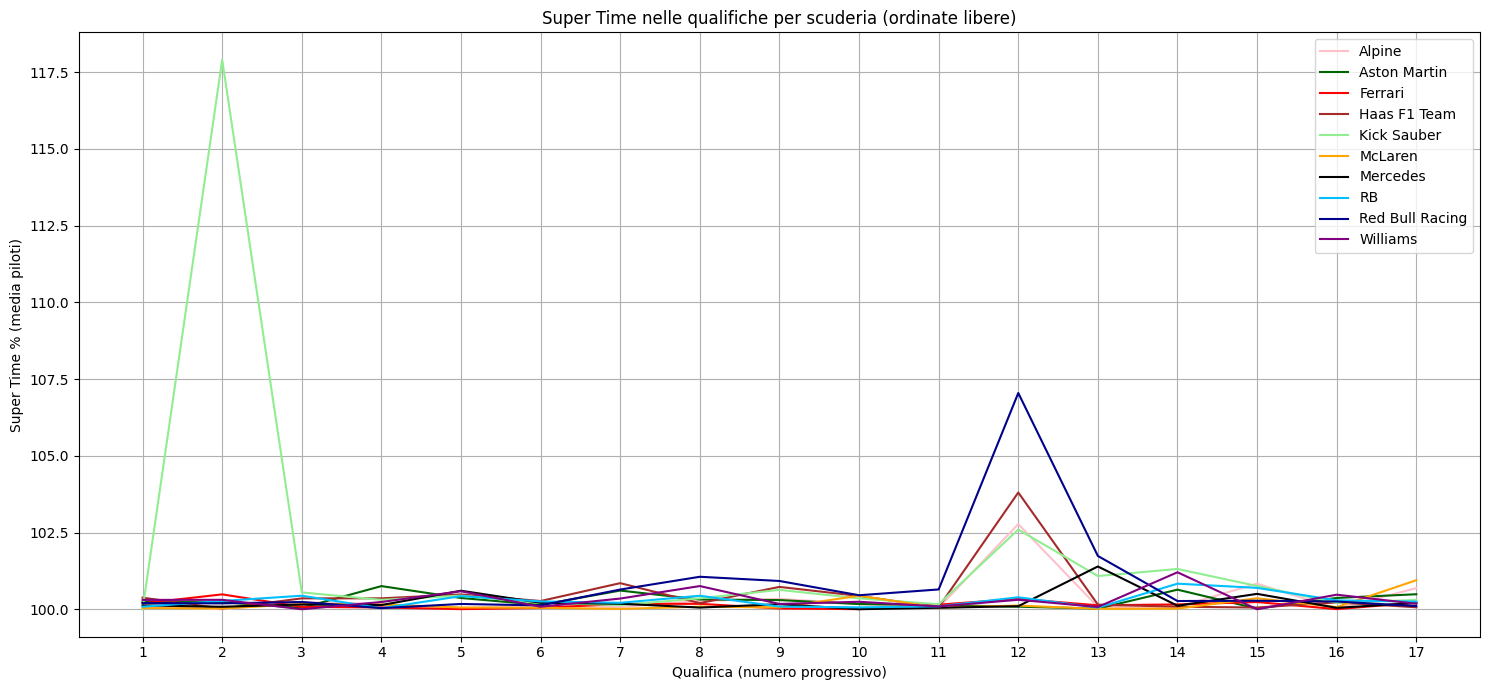

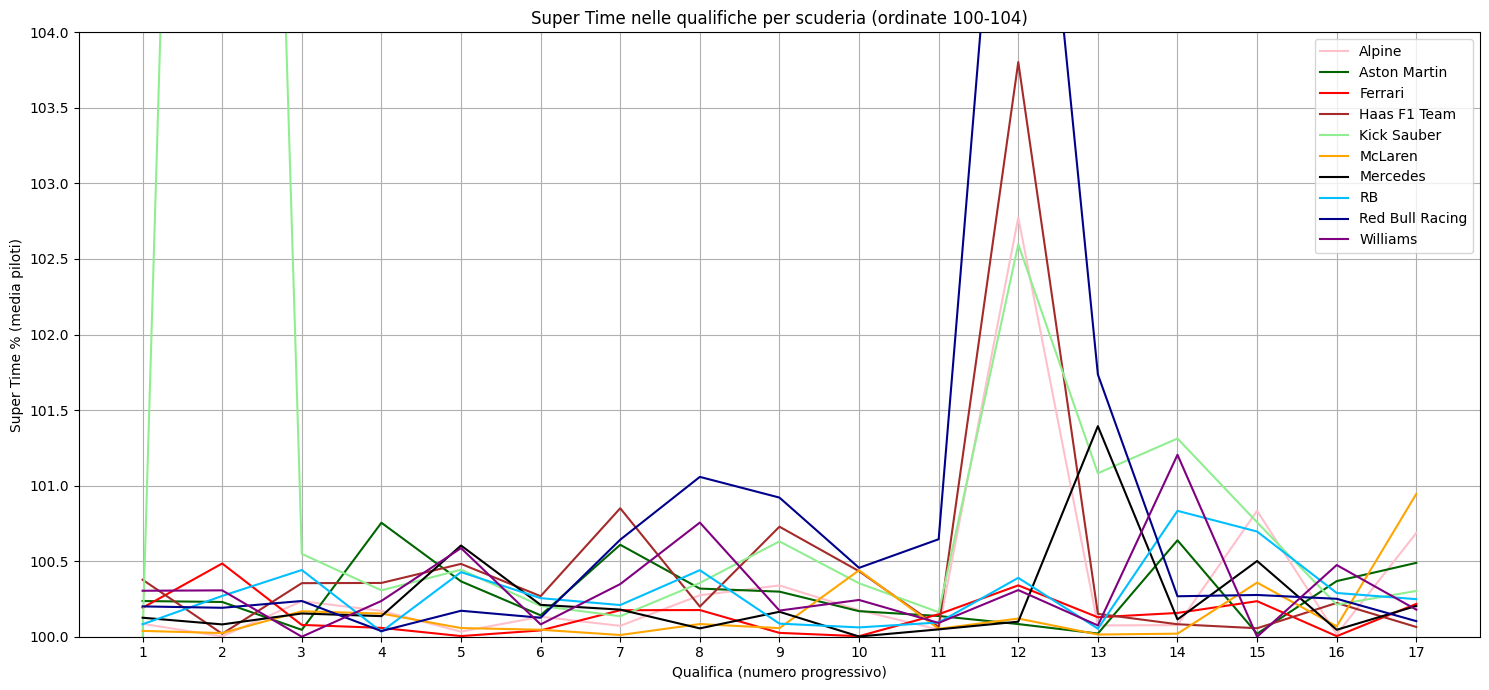

In [45]:
import matplotlib.pyplot as plt

# Mappa colori personalizzata per team
team_colors = {
    'Alpine': 'pink',
    'Aston Martin': 'darkgreen',
    'Ferrari': 'red',
    'Haas F1 Team': 'brown',
    'Kick Sauber': 'lightgreen',
    'McLaren': 'orange',
    'Mercedes': 'black',
    'RB': 'deepskyblue',
    'Red Bull Racing': 'darkblue',
    'Williams': 'purple'
}

# Figura con limiti ordinata non fissati
plt.figure(figsize=(15, 7))
for team, color in team_colors.items():
    team_data = final_qualy_df[final_qualy_df['Team'] == team]
    plt.plot(range(1, len(team_data)+1), team_data['SuperTime%_mean'], label=team, color=color)
plt.xlabel('Qualifica (numero progressivo)')
plt.ylabel('Super Time % (media piloti)')
plt.title('Super Time nelle qualifiche per scuderia (ordinate libere)')
plt.xticks(range(1, len(final_qualy_df['QUALY_ID'].unique())+1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Figura con limiti ordinata fissati
plt.figure(figsize=(15, 7))
for team, color in team_colors.items():
    team_data = final_qualy_df[final_qualy_df['Team'] == team]
    plt.plot(range(1, len(team_data)+1), team_data['SuperTime%_mean'], label=team, color=color)
plt.xlabel('Qualifica (numero progressivo)')
plt.ylabel('Super Time % (media piloti)')
plt.title('Super Time nelle qualifiche per scuderia (ordinate 100-104)')
plt.xticks(range(1, len(final_qualy_df['QUALY_ID'].unique())+1))
plt.ylim(100, 104)  # limite ordinata fissato
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


A differenza dei SuperTime durante le gare, nelle qualifiche la situazione cambia sensibilmente. Molti SuperTime di scuderie altalenanti nel corso della stagione tendono ad appiattirsi.  

Questo fenomeno è chiaramente legato alla durata della sessione: mentre le gare si estendono generalmente tra 1:20 e 2 ore, le qualifiche durano circa 45 minuti.  

Questa durata concentrata consente ai diversi costruttori di esprimere le massime prestazioni della vettura, cosa che non è possibile fare in gara a causa della gestione delle gomme e delle temperature interne della vettura.


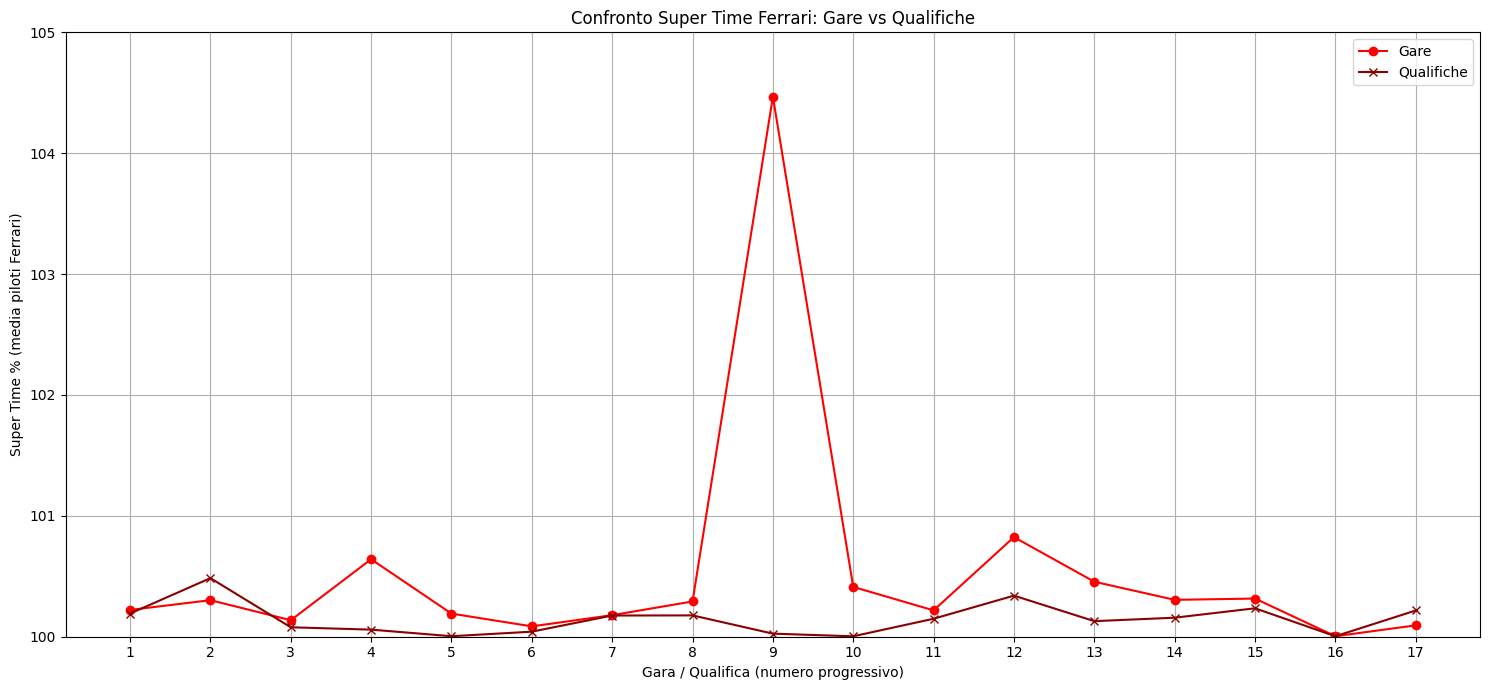

In [54]:
import matplotlib.pyplot as plt

# Filtra dati Ferrari e limita a 17 elementi
ferrari_gara = final_df[final_df['Team'] == 'Ferrari'].head(17)
ferrari_qualy = final_qualy_df[final_qualy_df['Team'] == 'Ferrari'].head(17)

plt.figure(figsize=(15, 7))

# Grafico gare
plt.plot(range(1, len(ferrari_gara)+1), ferrari_gara['SuperTime%_mean'], label='Gare', color='red', marker='o')

# Grafico qualifiche
plt.plot(range(1, len(ferrari_qualy)+1), ferrari_qualy['SuperTime%_mean'], label='Qualifiche', color='darkred', marker='x')

plt.xlabel('Gara / Qualifica (numero progressivo)')
plt.ylabel('Super Time % (media piloti Ferrari)')
plt.title('Confronto Super Time Ferrari: Gare vs Qualifiche')
plt.xticks(range(1, 18))  # ascisse fino a 17
plt.ylim(100, 105)        # ordinale compreso tra 100 e 104
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Per confrontare i Super Time tra gare e qualifiche, l'analisi si è concentrata sulla Ferrari.  
Dal grafico emerge che le prestazioni della scuderia sono generalmente molto vicine tra le due sessioni, evidenziando la costanza del team.  
Un'eccezione si nota nel Gran Premio del Canada, dove si osserva una differenza più marcata tra il Super Time in gara e quello in qualifica.

## Gran Premio di Montecarlo

Per evidenziare ulteriormente il ruolo cruciale delle qualifiche, viene analizzato il Gran Premio di Montecarlo.  
Questo circuito, noto per la sua conformazione stretta e tortuosa, mette in risalto soprattutto le strategie dei team piuttosto che le prestazioni individuali dei piloti, poiché è il gran premio con la media sorpassi più bassa di tutto il mondiale.


In [2]:
import fastf1
from pathlib import Path

# Percorso cache
cache_path = Path('/kaggle/working/cache')
cache_path.mkdir(parents=True, exist_ok=True)

# Abilita cache
fastf1.Cache.enable_cache(str(cache_path))

# Carica sessione Qualifiche Monaco 2024
session = fastf1.get_session(2024, 'Monaco', 'Q')
session.load()


core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for _extended_timing_data. Loading data...
_api           INFO 	Fetching timing data...
_api           INFO 	Parsing timing data...
req            INFO 	

Seguono i tempi ottenuti nelle tre fasi della qualifica: Q1, Q2 e Q3

In [4]:
import pickle
import pandas as pd
from pathlib import Path
from IPython.display import display

# Funzione per convertire timedelta in mm:ss.SSS
def format_lap_time(td):
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Cartella cache
cache_dir = Path('/kaggle/working/cache/2024/2024-05-26_Monaco_Grand_Prix/2024-05-25_Qualifying')

# Carica driver info
with open(cache_dir / 'driver_info.ff1pkl', 'rb') as f:
    driver_info = pickle.load(f)['data']
driver_names = {k: v['FullName'] for k, v in driver_info.items()}

# Carica extended timing data
with open(cache_dir / '_extended_timing_data.ff1pkl', 'rb') as f:
    laps_df = pickle.load(f)['data'][0]

# Carica session status
with open(cache_dir / 'session_status_data.ff1pkl', 'rb') as f:
    session_status = pickle.load(f)['data']
status_df = pd.DataFrame(session_status)

# Intervalli Q1, Q2, Q3
q1_start, q1_end = status_df.loc[1, 'Time'], status_df.loc[2, 'Time']
q2_start, q2_end = status_df.loc[4, 'Time'], status_df.loc[5, 'Time']
q3_start, q3_end = status_df.loc[7, 'Time'], status_df.loc[8, 'Time']

# Filtra i lap per ciascuna fase
q1_laps = laps_df[(laps_df['Time'] >= q1_start) & (laps_df['Time'] <= q1_end)]
q2_laps = laps_df[(laps_df['Time'] >= q2_start) & (laps_df['Time'] <= q2_end)]
q3_laps = laps_df[(laps_df['Time'] >= q3_start) & (laps_df['Time'] <= q3_end)]

# Funzione per prendere il giro migliore di ciascun pilota
def best_laps(df):
    best = df.loc[df.groupby('Driver')['LapTime'].idxmin()]
    best['DriverName'] = best['Driver'].map(driver_names)
    best['LapTimeStr'] = best['LapTime'].apply(format_lap_time)
    best['Sector1Str'] = best['Sector1Time'].apply(format_lap_time)
    best['Sector2Str'] = best['Sector2Time'].apply(format_lap_time)
    best['Sector3Str'] = best['Sector3Time'].apply(format_lap_time)
    return best[['DriverName','LapTimeStr','Sector1Str','Sector2Str','Sector3Str']].sort_values('LapTimeStr')

# Applica a Q1, Q2, Q3
q1_times = best_laps(q1_laps)
q2_times = best_laps(q2_laps)
q3_times = best_laps(q3_laps)

# Mostra risultati
display(q1_times.style.set_caption("Q1 - Monaco 2024"))
display(q2_times.style.set_caption("Q2 - Monaco 2024"))
display(q3_times.style.set_caption("Q3 - Monaco 2024"))


,DriverName,LapTimeStr,Sector1Str,Sector2Str,Sector3Str
127,George RUSSELL,01:11.492,00:18.544,00:33.894,00:19.054
64,Lewis HAMILTON,01:11.528,00:18.689,00:33.784,00:19.055
8,Charles LECLERC,01:11.584,00:18.597,00:33.825,00:19.162
34,Max VERSTAPPEN,01:11.711,00:18.612,00:33.970,00:19.129
341,Lance STROLL,01:11.728,00:18.643,00:33.850,00:19.235
276,Alexander ALBON,01:11.753,00:18.748,00:33.940,00:19.065
322,Kevin MAGNUSSEN,01:11.832,00:18.696,00:33.969,00:19.167
207,Yuki TSUNODA,01:11.852,00:18.845,00:33.582,00:19.425
302,Nico HULKENBERG,01:11.876,00:18.824,00:33.857,00:19.195
86,Oscar PIASTRI,01:11.881,00:18.771,00:33.733,00:19.377


,DriverName,LapTimeStr,Sector1Str,Sector2Str,Sector3Str
193,Lando NORRIS,01:10.732,00:18.432,00:33.415,00:18.885
45,Max VERSTAPPEN,01:10.745,00:18.292,00:33.502,00:18.951
98,Oscar PIASTRI,01:10.756,00:18.471,00:33.291,00:18.994
16,Charles LECLERC,01:10.825,00:18.480,00:33.440,00:18.905
135,George RUSSELL,01:10.929,00:18.461,00:33.498,00:18.970
74,Lewis HAMILTON,01:11.056,00:18.479,00:33.600,00:18.977
161,Carlos SAINZ,01:11.075,00:18.669,00:33.543,00:18.863
287,Alexander ALBON,01:11.216,00:18.594,00:33.684,00:18.938
212,Yuki TSUNODA,01:11.257,00:18.711,00:33.551,00:18.995
365,Esteban OCON,01:11.285,00:18.701,00:33.539,00:19.045


,DriverName,LapTimeStr,Sector1Str,Sector2Str,Sector3Str
24,Charles LECLERC,01:10.270,00:18.386,00:33.174,00:18.710
104,Oscar PIASTRI,01:10.424,00:18.303,00:33.380,00:18.741
172,Carlos SAINZ,01:10.518,00:18.494,00:33.241,00:18.783
199,Lando NORRIS,01:10.542,00:18.466,00:33.340,00:18.736
144,George RUSSELL,01:10.543,00:18.244,00:33.462,00:18.837
49,Max VERSTAPPEN,01:10.567,00:18.255,00:33.424,00:18.888
80,Lewis HAMILTON,01:10.621,00:18.372,00:33.439,00:18.810
224,Yuki TSUNODA,01:10.858,00:18.595,00:33.470,00:18.793
294,Alexander ALBON,01:10.948,00:18.487,00:33.597,00:18.864
261,Pierre GASLY,01:11.311,00:18.637,00:33.599,00:19.075


Come si può osservare, i tempi di ciascun pilota variano da una sessione all'altra:

- **Q1**: i piloti che puntano alla pole position tendono a testare il terreno e le condizioni della pista per le fasi successive, quindi non effettuano giri massimali (hammer time).  
- **Q2**: i tempi iniziano a scendere poiché è necessario assicurarsi l’accesso alla Q3. Rimanere fuori da questa fase sarebbe un problema serio per un top team.  
- **Q3**: i piloti cercano di ottenere i tempi migliori possibili. Questa fase è cruciale per determinare l’andamento della gara, soprattutto considerando il tipo di circuito analizzato.


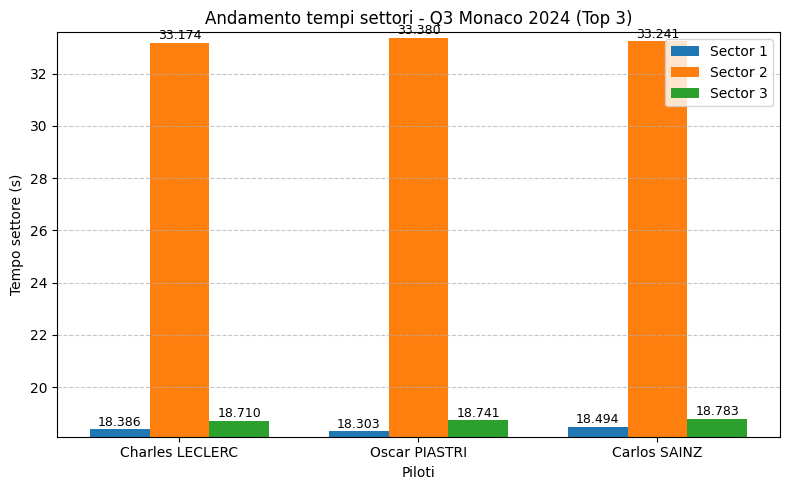

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Top 3 piloti in Q3
q3_top3 = q3_times.sort_values('LapTimeStr').head(3)

# Converti tempi settori in secondi
def time_to_seconds(t):
    mins, secs = t.split(':')
    return float(mins) * 60 + float(secs)

sector1 = q3_top3['Sector1Str'].apply(time_to_seconds)
sector2 = q3_top3['Sector2Str'].apply(time_to_seconds)
sector3 = q3_top3['Sector3Str'].apply(time_to_seconds)
drivers = q3_top3['DriverName']

# Posizioni barre
x = np.arange(len(drivers))
width = 0.25

# Limiti asse y centrati sui minimi e massimi dei settori
y_min = min(sector1.min(), sector2.min(), sector3.min()) - 0.2
y_max = max(sector1.max(), sector2.max(), sector3.max()) + 0.2

# Grafico a barre
plt.figure(figsize=(8,5))
bars1 = plt.bar(x - width, sector1, width, label='Sector 1')
bars2 = plt.bar(x, sector2, width, label='Sector 2')
bars3 = plt.bar(x + width, sector3, width, label='Sector 3')

# Aggiungi etichette con valori
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9)

plt.xticks(x, drivers)
plt.xlabel('Piloti')
plt.ylabel('Tempo settore (s)')
plt.ylim(y_min, y_max)
plt.title('Andamento tempi settori - Q3 Monaco 2024 (Top 3)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Dato che il circuito di Montecarlo è il più corto del mondiale di Formula 1, con i suoi **3,337 km**, la differenza tra i piloti si misura principalmente in **decimi di secondo**, e non in centesimi come avviene su circuiti più lunghi.  

Dal grafico dei tempi settoriali della Q3 si evidenzia che nella **top 3** le differenze sono minime, e non emerge un pilota dominante su tutti i settori:

- **Sector 1 (S1)**: Piastri, Leclerc, Sainz  
- **Sector 2 (S2)**: Leclerc, Sainz, Piastri  
- **Sector 3 (S3)**: Leclerc, Piastri, Sainz


In [18]:
from IPython.display import display, Image

url = "https://upload.wikimedia.org/wikipedia/commons/5/56/Circuit_Monaco.svg"
display(Image(url=url, width=600))

- **Sector 1 (S1)**: Linea di inizio → T4  
- **Sector 2 (S2)**: Uscita T4 → Entrata T10  
- **Sector 3 (S3)**: Uscita T10 → Linea di inizio  

Nonostante i settori siano simili in termini di lunghezza, il **secondo settore (S2)** risulta notevolmente più lento.  
Questo è dovuto al sottosettore **T5-T8**, che include il tornante alla **T6**, costringendo i piloti a velocità estremamente basse.


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


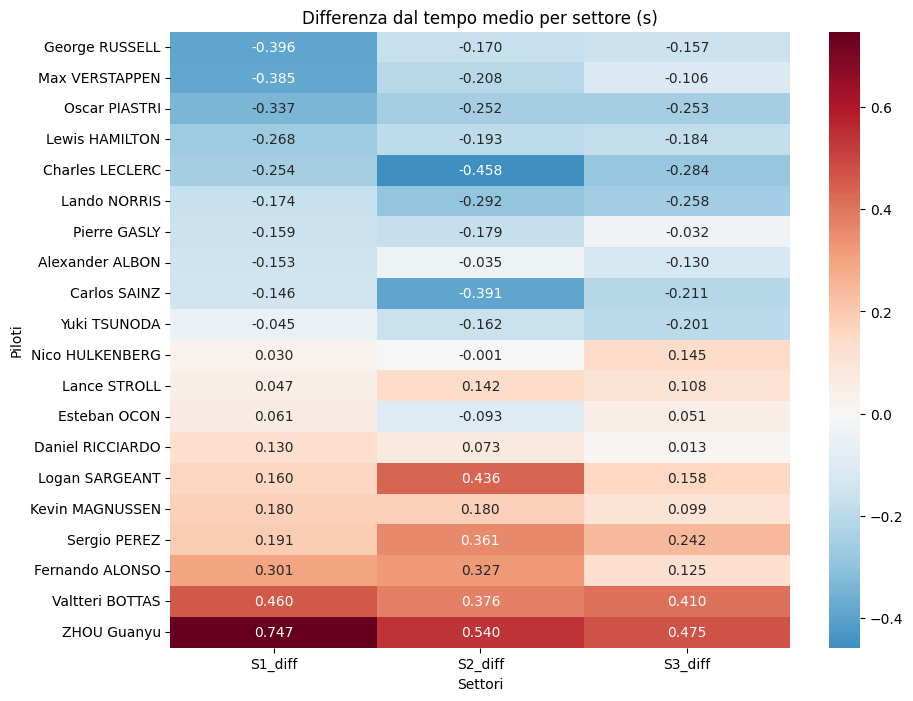

In [9]:
import pickle
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per convertire timedelta in mm:ss.SSS
def format_lap_time(td):
    total_seconds = td.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes:02d}:{seconds:06.3f}"

# Cartella cache
cache_dir = Path('/kaggle/working/cache/2024/2024-05-26_Monaco_Grand_Prix/2024-05-25_Qualifying')

# Carica driver info
with open(cache_dir / 'driver_info.ff1pkl', 'rb') as f:
    driver_info = pickle.load(f)['data']
driver_names = {k: v['FullName'] for k, v in driver_info.items()}

# Carica extended timing data
with open(cache_dir / '_extended_timing_data.ff1pkl', 'rb') as f:
    laps_df = pickle.load(f)['data'][0]

# Ottieni il giro migliore di ciascun pilota su tutta la sessione
best_laps_all = laps_df.loc[laps_df.groupby('Driver')['LapTime'].idxmin()].copy()
best_laps_all['DriverName'] = best_laps_all['Driver'].map(driver_names)

# Converti i settori in secondi
best_laps_all['S1_sec'] = best_laps_all['Sector1Time'].apply(lambda td: td.total_seconds())
best_laps_all['S2_sec'] = best_laps_all['Sector2Time'].apply(lambda td: td.total_seconds())
best_laps_all['S3_sec'] = best_laps_all['Sector3Time'].apply(lambda td: td.total_seconds())

# Calcola tempo medio per settore
avg_sectors = best_laps_all[['S1_sec','S2_sec','S3_sec']].mean()

# Calcola deviazione dalla media per ogni settore per heatmap
best_laps_all['S1_diff'] = best_laps_all['S1_sec'] - avg_sectors['S1_sec']
best_laps_all['S2_diff'] = best_laps_all['S2_sec'] - avg_sectors['S2_sec']
best_laps_all['S3_diff'] = best_laps_all['S3_sec'] - avg_sectors['S3_sec']

# Costruisci DataFrame per heatmap
heatmap_df = best_laps_all.set_index('DriverName')[['S1_diff','S2_diff','S3_diff']]

# Ordina piloti per tempo totale del giro migliore
heatmap_df = heatmap_df.loc[best_laps_all.sort_values(['S1_sec','S2_sec','S3_sec']).DriverName]

# Visualizza heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, fmt=".3f", cmap="RdBu_r", center=0)
plt.title("Differenza dal tempo medio per settore (s)")
plt.ylabel("Piloti")
plt.xlabel("Settori")
plt.show()


Dal grafico si osserva che i **piloti top mantengono un rendimento costante al di sotto del tempo medio di ciascun settore**.

In particolare:

- **Charles Leclerc** ha conquistato la pole sfruttando al massimo il **Settore 2 (S2)**, che è il settore più lento del circuito e dove è possibile guadagnare più decimi rispetto agli avversari.  
- Nonostante **Max Verstappen** disponesse della macchina più veloce (come evidenziato dal suo vantaggio in **S1**, il settore in cui la Red Bull è più competitiva grazie al tipo di curve), nel circuito di Montecarlo **la differenza non la fa la velocità di punta della vettura**, ma la **costanza dei piloti**.

Questo evidenzia come, su tracciati corti e tortuosi, **la precisione e la gestione dei settori siano determinanti** più della pura potenza della monoposto.

In [15]:
# Calcola il miglior tempo per settore e il pilota corrispondente
best_S1_idx = laps_df['Sector1Time'].idxmin()
best_S2_idx = laps_df['Sector2Time'].idxmin()
best_S3_idx = laps_df['Sector3Time'].idxmin()

# Usa la funzione format_lap_time per convertire i tempi
best_S1_time_str = format_lap_time(laps_df.loc[best_S1_idx, 'Sector1Time'])
best_S2_time_str = format_lap_time(laps_df.loc[best_S2_idx, 'Sector2Time'])
best_S3_time_str = format_lap_time(laps_df.loc[best_S3_idx, 'Sector3Time'])

best_S1_driver = driver_names[laps_df.loc[best_S1_idx, 'Driver']]
best_S2_driver = driver_names[laps_df.loc[best_S2_idx, 'Driver']]
best_S3_driver = driver_names[laps_df.loc[best_S3_idx, 'Driver']]

# Calcola l'ideal lap
ideal_lap_time = laps_df.loc[best_S1_idx, 'Sector1Time'] + \
                 laps_df.loc[best_S2_idx, 'Sector2Time'] + \
                 laps_df.loc[best_S3_idx, 'Sector3Time']
ideal_lap_time_str = format_lap_time(ideal_lap_time)

# Crea DataFrame
ideal_lap_df = pd.DataFrame({
    'Sector': ['S1', 'S2', 'S3', 'Total'],
    'TimeStr': [best_S1_time_str, best_S2_time_str, best_S3_time_str, ideal_lap_time_str],
    'BestDriver': [best_S1_driver, best_S2_driver, best_S3_driver, 'IdealLap']
})

# Mostra DataFrame
display(ideal_lap_df)


,Sector,TimeStr,BestDriver
0,S1,00:18.244,George RUSSELL
1,S2,00:33.156,Oscar PIASTRI
2,S3,00:18.710,Charles LECLERC
3,Total,01:10.110,IdealLap


Giro Ideale

Questo rappresenta il **giro ideale**, combinando i migliori tempi in ciascun settore tra tutti i piloti.  

Si nota come **Leclerc** abbia disputato un'ottima qualifica, distanziandosi dal giro ideale di soli **0,16 s**.


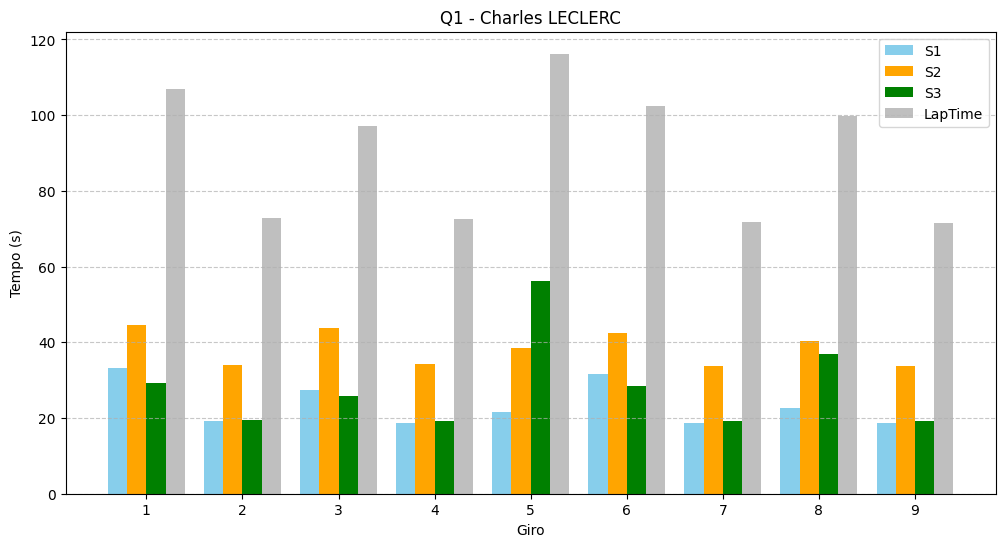

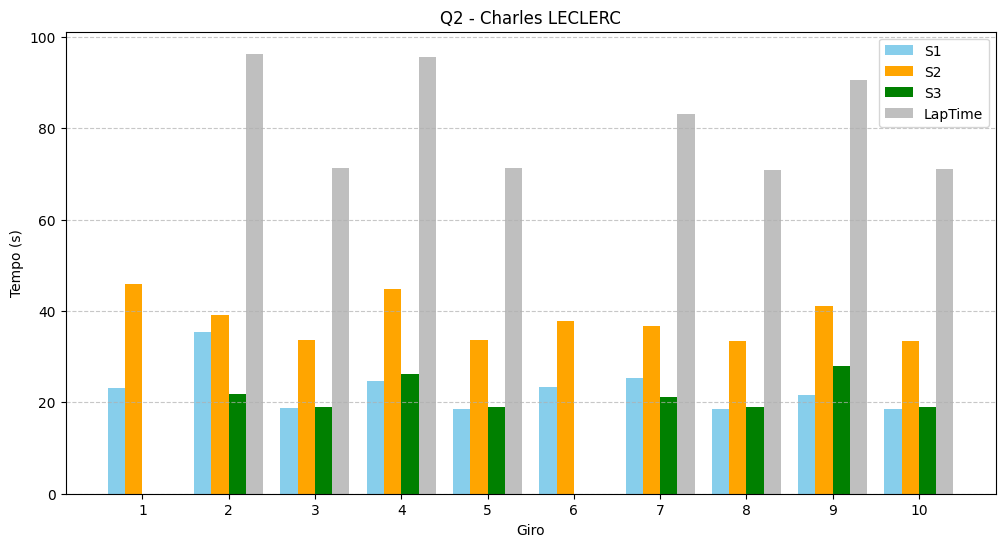

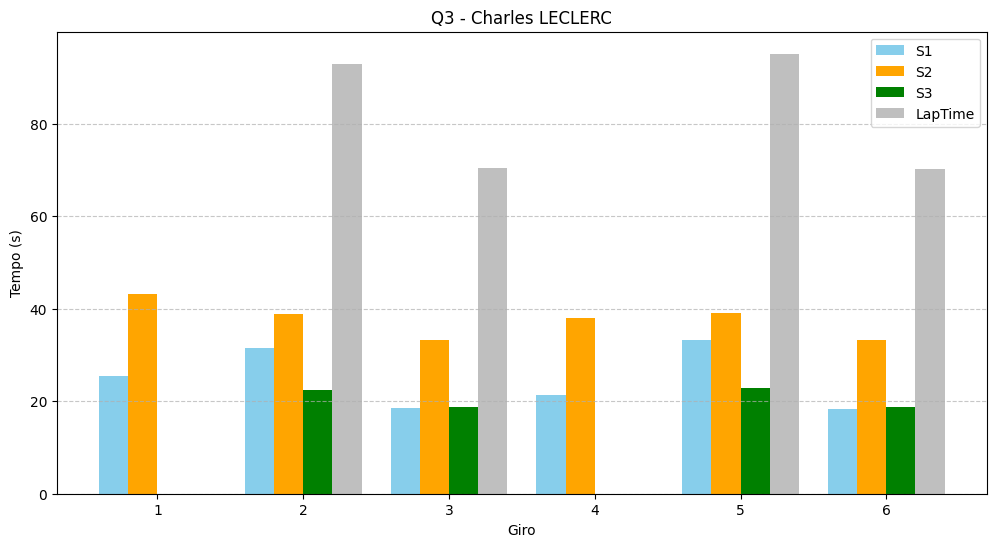

In [12]:
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Funzione per convertire timedelta in secondi
def td_to_sec(td):
    return td.total_seconds()

# Cartella cache
cache_dir = Path('/kaggle/working/cache/2024/2024-05-26_Monaco_Grand_Prix/2024-05-25_Qualifying')

# Carica driver info
with open(cache_dir / 'driver_info.ff1pkl', 'rb') as f:
    driver_info = pickle.load(f)['data']
driver_names = {k: v['FullName'] for k, v in driver_info.items()}

# Trova l'ID di Charles Leclerc
driver_id = [k for k, v in driver_names.items() if v == "Charles LECLERC"][0]

# Carica extended timing data
with open(cache_dir / '_extended_timing_data.ff1pkl', 'rb') as f:
    laps_df = pickle.load(f)['data'][0]

# Carica session status
with open(cache_dir / 'session_status_data.ff1pkl', 'rb') as f:
    session_status = pickle.load(f)['data']
status_df = pd.DataFrame(session_status)

# Intervalli Q1, Q2, Q3
q1_start, q1_end = status_df.loc[1, 'Time'], status_df.loc[2, 'Time']
q2_start, q2_end = status_df.loc[4, 'Time'], status_df.loc[5, 'Time']
q3_start, q3_end = status_df.loc[7, 'Time'], status_df.loc[8, 'Time']

# Funzione per filtrare i lap di un pilota in una sessione
def filter_driver_laps(df, driver_id, start, end):
    laps = df[(df['Driver'] == driver_id) & (df['Time'] >= start) & (df['Time'] <= end)].copy()
    laps['LapTime_sec'] = laps['LapTime'].apply(td_to_sec)
    laps['S1_sec'] = laps['Sector1Time'].apply(td_to_sec)
    laps['S2_sec'] = laps['Sector2Time'].apply(td_to_sec)
    laps['S3_sec'] = laps['Sector3Time'].apply(td_to_sec)
    return laps

# Filtra le sessioni
q1_laps = filter_driver_laps(laps_df, driver_id, q1_start, q1_end)
q2_laps = filter_driver_laps(laps_df, driver_id, q2_start, q2_end)
q3_laps = filter_driver_laps(laps_df, driver_id, q3_start, q3_end)

# Funzione per plottare i tempi di una sessione con bar plot
def plot_session_bars(laps, session_name):
    x = np.arange(len(laps))
    width = 0.2
    plt.figure(figsize=(12,6))
    plt.bar(x - width*1.5, laps['S1_sec'], width, label='S1', color='skyblue')
    plt.bar(x - width/2, laps['S2_sec'], width, label='S2', color='orange')
    plt.bar(x + width/2, laps['S3_sec'], width, label='S3', color='green')
    plt.bar(x + width*1.5, laps['LapTime_sec'], width, label='LapTime', color='gray', alpha=0.5)
    plt.xticks(x, range(1, len(laps)+1))
    plt.xlabel('Giro')
    plt.ylabel('Tempo (s)')
    plt.title(f"{session_name} - Charles LECLERC")
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plotta le tre sessioni
plot_session_bars(q1_laps, "Q1")
plot_session_bars(q2_laps, "Q2")
plot_session_bars(q3_laps, "Q3")


Analisi dei giri di Charles LECLERC nelle qualifiche di Monaco 2024

- **Q1:**  
  Sui 9 giri effettuati, il 1°, 5° e 8° giro sono giri di lancio.  
  Il 3° giro presenta un tempo più alto rispetto agli altri push lap, probabilmente a causa del traffico.  
  Nei settori stretti del circuito, in particolare S2, il traffico rende impossibile realizzare un giro competitivo.  
  Negli altri push lap, le prestazioni risultano molto costanti.

- **Q2:**  
  Il 1° e il 6° giro non sono completi, dovuto agli stop ai box.  
  La strategia alterna preparation lap e push lap, diversamente dal Q1 dove alcuni push lap sono stati scartati per il traffico.  
  Nei push lap, le prestazioni rimangono costanti.

- **Q3:**  
  Numero inferiore di giri a causa della durata ridotta della qualifica (12 minuti vs 18 e 15 minuti in Q1 e Q2).  
  Le prestazioni sui giri effettuati rimangono costanti anche in questa fase.

Per una comprensione più approfondita delle prestazioni, è necessario analizzare la telemetria 

core           INFO 	Loading data for Monaco Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '31', '3', '18', '27', '14', '2', '20', '11', '77', '24']
/usr/local/lib/python3.11/dist-packages/fastf1/core.py:3183: FutureWarning: pick_driver is deprecated and will

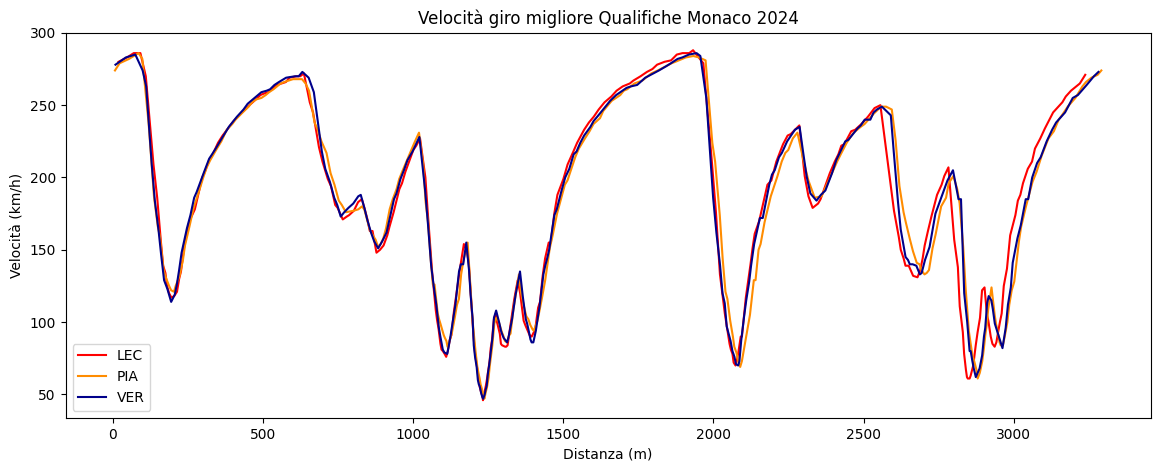

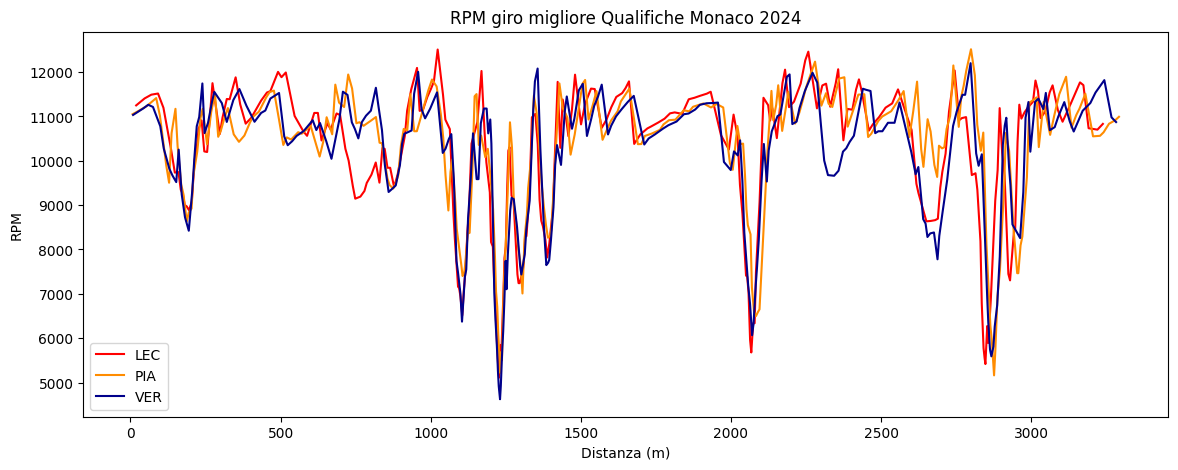

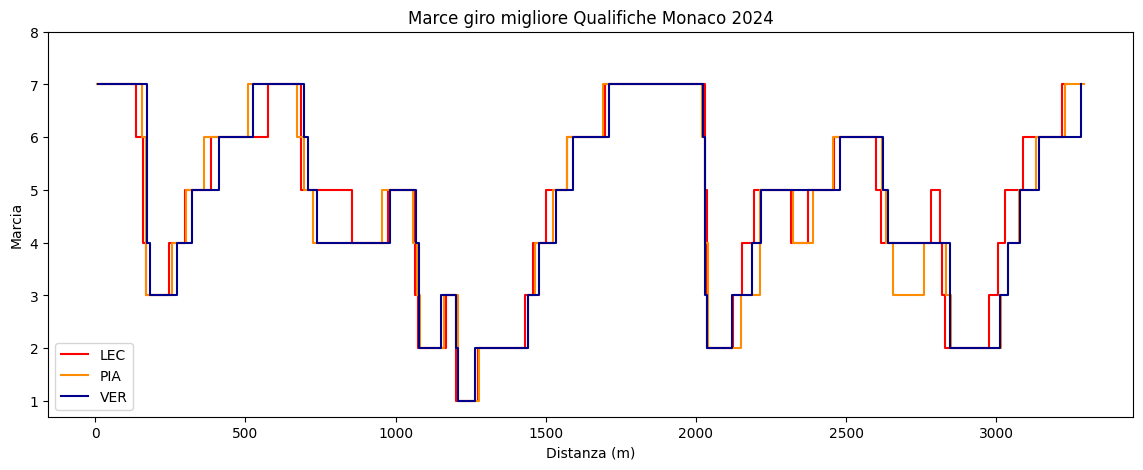

In [33]:
import fastf1
from fastf1 import plotting
import matplotlib.pyplot as plt
from pathlib import Path

# Crea la cartella cache se non esiste
cache_path = Path('/kaggle/working/cache/fastf1')
cache_path.mkdir(parents=True, exist_ok=True)

# Abilita cache
fastf1.Cache.enable_cache(cache_path)

# Carica sessione qualifiche Monaco 2024
session = fastf1.get_session(2024, 'Monaco', 'Q')
session.load(telemetry=True)

# Seleziona i giri migliori dei tre piloti
drivers = {'LEC': 'red', 'PIA': 'darkorange', 'VER': 'darkblue'}
best_laps = {drv: session.laps.pick_driver(drv).pick_fastest() for drv in drivers}

# Ottieni telemetria e aggiungi distanza
telemetries = {drv: lap.get_car_data().add_distance() for drv, lap in best_laps.items()}

# Grafico velocità vs distanza
plt.figure(figsize=(14,5))
for drv, color in drivers.items():
    plt.plot(telemetries[drv]['Distance'], telemetries[drv]['Speed'], color=color, label=drv)
plt.xlabel('Distanza (m)')
plt.ylabel('Velocità (km/h)')
plt.title('Velocità giro migliore Qualifiche Monaco 2024')
plt.legend()
plt.show()

# Grafico RPM vs distanza
plt.figure(figsize=(14,5))
for drv, color in drivers.items():
    plt.plot(telemetries[drv]['Distance'], telemetries[drv]['RPM'], color=color, label=drv)
plt.xlabel('Distanza (m)')
plt.ylabel('RPM')
plt.title('RPM giro migliore Qualifiche Monaco 2024')
plt.legend()
plt.show()

# Grafico marce vs distanza
plt.figure(figsize=(14,5))
for drv, color in drivers.items():
    plt.step(telemetries[drv]['Distance'], telemetries[drv]['nGear'], where='post', color=color, label=drv)
plt.xlabel('Distanza (m)')
plt.ylabel('Marcia')
plt.title('Marce giro migliore Qualifiche Monaco 2024')
plt.yticks(range(1, 9))
plt.legend()
plt.show()


Nei seguenti grafici sono mostrati rispettivamente la **velocità**, **RPM** e **marce** di Leclerc, Piastri e Verstappen. Dai grafici si osserva quanto segue:

- **Velocità**: i grafici dei tre piloti sono molto simili. Il giro di Leclerc risulta leggermente traslato a sinistra grazie al vantaggio accumulato durante il settore S2, in particolare in entrata alla T13. Piastri e Verstappen si equivalgono, con leggere differenze nella percorrenza delle curve, che tuttavia non influenzano significativamente il termine del giro.

- **RPM**: emergono differenze tra i motori delle vetture. Il motore Ferrari di Leclerc registra picchi di RPM più alti, ma evidenzia un calo in ingresso alla T3. La McLaren di Piastri mantiene valori medi di RPM con un picco in T14, differenziandosi dalle altre due vetture. Il giro di Verstappen subisce un calo in ingresso alla T12, probabilmente dovuto alla frenata, che si riflette anche nel grafico della velocità. Leclerc, invece, entra con RPM più alti e riesce a uscire prima dalla curva.

- **Marce**: si notano differenze nello stile di guida dei piloti. Piastri in T14 registra un picco di RPM dovuto allo scalamento 4→3, probabilmente per sfruttare il freno motore. Per il resto del giro, Piastri e Verstappen guidano in modo simile, mentre Leclerc cambia il timing per salire e scalare marcia. La differenza sul giro è data dallo scalamento in preparazione di T13, effettuato anche da Piastri, che però sbaglia nel preparare T14, perdendo il vantaggio momentaneo rispetto a Verstappen, che non ha scalato in preparazione di T13. Questo errore contribuisce al tempo perso nel settore S2.



In [60]:
import fastf1
import pandas as pd

# --- Caricamento sessione di gara 2024 Monaco GP ---
fastf1.Cache.enable_cache('/kaggle/working/cache/fastf1')
session = fastf1.get_session(2024, 'Monaco', 'R')  # 'R' per Race
session.load()

# --- Estrai i dati dei giri ---
laps_df = session.laps[['Driver', 'LapNumber', 'Position']]

# --- Posizioni finali: ultimo giro completato da ciascun pilota ---
finish_positions = laps_df.groupby('Driver').last().reset_index()
finish_positions = finish_positions[['Driver', 'Position']]
finish_positions = finish_positions.rename(columns={'Position': 'FinishPosition'}).set_index('Driver')

# Ordina per FinishPosition crescente
finish_positions = finish_positions.sort_values('FinishPosition')

# Mostra tabella posizioni finali ordinate
display(finish_positions)

# --- Posizioni iniziali (Q1/Q2/Q3) ---
def get_start_positions(q1, q2, q3):
    # Q3: piloti qualificati per Q3 → posizioni 1-10
    q3_order = q3['DriverName'].tolist()
    q3_positions = pd.DataFrame({
        'DriverName': q3_order,
        'StartPosition': range(1, len(q3_order)+1)
    })

    # Q2: piloti eliminati in Q2 → posizioni 11-15
    q2_eliminated = q2.tail(5)['DriverName'].tolist()
    q2_positions = pd.DataFrame({
        'DriverName': q2_eliminated,
        'StartPosition': range(11, 16)
    })

    # Q1: piloti eliminati in Q1 → posizioni 16-20
    q1_eliminated = q1.tail(5)['DriverName'].tolist()
    q1_positions = pd.DataFrame({
        'DriverName': q1_eliminated,
        'StartPosition': range(16, 21)
    })

    # Combina tutto e rimuove duplicati mantenendo il primo
    start_positions = pd.concat([q3_positions, q2_positions, q1_positions], ignore_index=True)
    start_positions = start_positions.drop_duplicates(subset='DriverName', keep='first')
    start_positions = start_positions.set_index('DriverName')
    return start_positions

# Ottieni start positions senza duplicati
start_positions = get_start_positions(q1_times, q2_times, q3_times)

# Mostra tabella posizioni iniziali
display(start_positions)


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/forma

,FinishPosition
Driver,
LEC,1.0
PIA,2.0
SAI,3.0
NOR,4.0
RUS,5.0
VER,6.0
HAM,7.0
TSU,8.0
ALB,9.0


,StartPosition
DriverName,
Charles LECLERC,1
Oscar PIASTRI,2
Carlos SAINZ,3
Lando NORRIS,4
George RUSSELL,5
Max VERSTAPPEN,6
Lewis HAMILTON,7
Yuki TSUNODA,8
Alexander ALBON,9


I cambiamenti al termine della gara in termini di posizioni sono dovuti al ritiro di 4 piloti: Hulkemberg, Magnussen, Ocon e Perez. Per il resto le posizioni sono rimaste invariate. Questo evidenzia come la qualifica nel circuito di MonteCarlo sia fondamentale, in quanto, come spesso accade, ci sono stati 0 sorpassi fisici in Gara. L'unico modo per guadagnare posizioni è sfruttare le virtual car o tramite strategie di pit, che non possono essere analizzate visti i dati incompleti.